# Custom Training Walkthrough: Refresher

This Notebook is to just quickly recall the API covered in the [Custom training: walkthrough](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough) TF tutorial. 

The tutorial demonstrates how to:
1. Load data using the [TenworFlow Datasets API](https://www.tensorflow.org/datasets/overview#load_a_dataset)
2. Use [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) class to make a model
3. Build a custom training loop to train the model.


## Setup

Just prepare TF for the usage. This step includes:
1. Import python modules that will be used throughout the notebook
2. Disable the unwanted redundant TF logging
3. Fix duplicated binary paths. This is related only to my personal environment which I will fix a bit later. So I'll make this step a little bit dirty, it's ok, I guess.


In [1]:
import os 

# Suppress unwnted TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# Fix duplicated CUDA paths (only on my current env):
from socket import gethostname
if gethostname() == 'stepan-pc':
    OTHER_PATHS = os.environ['PATH']
    CUDA_12_5_PATH = '/usr/local/cuda-12.5/bin'
    os.environ['PATH']=f'{CUDA_12_5_PATH}:{OTHER_PATHS}'

Now import TF and Matplotlib modules

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

## Install TensorFlow Datasets API

Just make sure that [TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) (aka TFDS) API is available. 

According to the documentation TFDS exists in two packages: `tensorflow-datasets` (released every few month) and `tfds-nightly` (released daily). 


Install dependency:
```
poetry add tensorflow-datasets
```

In [3]:
import tensorflow_datasets as tfds

## Import the dataset 

Before downloading the preprocessed data, it worth to examine the original penguin survey data.

### Preview the Data

Download the simplified version of the penguins dataset (`"penguins/simple"`) using the [tfds.load](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In [4]:
preview, preview_info = tfds.load('penguins/simple', split='train', with_info=True)
preview_df = tfds.as_dataframe(preview, preview_info)
preview_df.info()

<class 'tensorflow_datasets.core.as_dataframe.as_dataframe.<locals>.StyledDataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   body_mass_g        342 non-null    float32
 1   culmen_depth_mm    342 non-null    float32
 2   culmen_length_mm   342 non-null    float32
 3   flipper_length_mm  342 non-null    float32
 4   island             344 non-null    int64  
 5   sex                344 non-null    int64  
 6   species            344 non-null    int64  
dtypes: float32(4), int64(3)
memory usage: 13.6 KB


In [5]:
preview_df.head()

,body_mass_g,culmen_depth_mm,culmen_length_mm,flipper_length_mm,island,sex,species
0,4200.0,13.9,45.500000,210.0,0,0,2
1,4650.0,13.7,40.900002,214.0,0,0,2
2,5300.0,14.2,51.299999,218.0,0,1,2
3,5650.0,15.0,47.799999,215.0,0,1,2
4,5050.0,15.8,46.299999,215.0,0,1,2


In [6]:
preview_df.describe()

,body_mass_g,culmen_depth_mm,culmen_length_mm,flipper_length_mm,island,sex,species
count,342.000000,342.000000,342.000000,342.000000,344.000000,344.000000,344.000000
mean,4201.754395,17.151171,43.921932,200.915207,0.662791,0.552326,0.918605
std,801.954529,1.974793,5.459584,14.061714,0.726194,0.558680,0.893320
min,2700.000000,13.100000,32.099998,172.000000,0.000000,0.000000,0.000000
25%,3550.000000,15.600000,39.224998,190.000000,0.000000,0.000000,0.000000
50%,4050.000000,17.299999,44.450001,197.000000,1.000000,1.000000,1.000000
75%,4750.000000,18.700001,48.500000,213.000000,1.000000,1.000000,2.000000
max,6300.000000,21.500000,59.599998,231.000000,2.000000,2.000000,2.000000


array([[<Axes: title={'center': 'body_mass_g'}>,
        <Axes: title={'center': 'culmen_depth_mm'}>,
        <Axes: title={'center': 'culmen_length_mm'}>],
       [<Axes: title={'center': 'flipper_length_mm'}>,
        <Axes: title={'center': 'island'}>,
        <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'species'}>, <Axes: >, <Axes: >]],
      dtype=object)

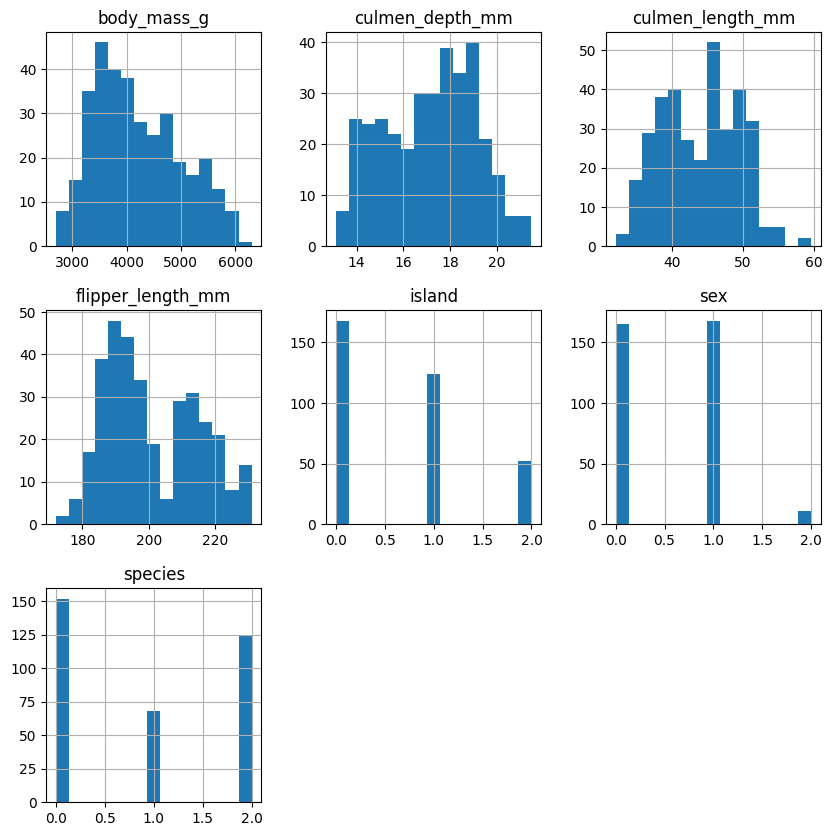

In [14]:
preview_df.hist(bins=15, figsize=(10,10))

<Axes: xlabel='body_mass_g', ylabel='culmen_length_mm'>

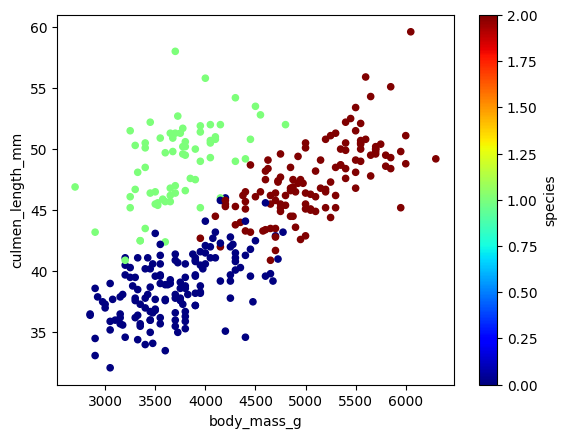

In [15]:
preview_df.plot(kind="scatter", x='body_mass_g', y='culmen_length_mm', c='species', cmap='jet')

<Axes: xlabel='body_mass_g', ylabel='flipper_length_mm'>

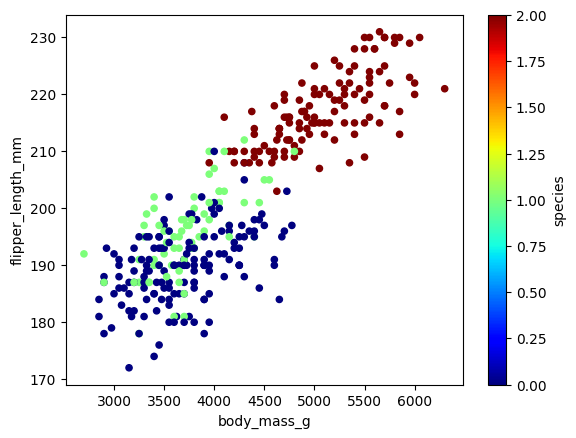

In [16]:
preview_df.plot(kind='scatter', x='body_mass_g', y='flipper_length_mm', c='species', cmap='jet')

In [65]:
def scatter3d(data, colors):
    """Show 3D scatter plot."""
    fig = plt.figure(figsize=(8, 8), dpi=80)
    axes = fig.add_subplot(projection="3d")
    axes.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.5, c=colors)
    return fig

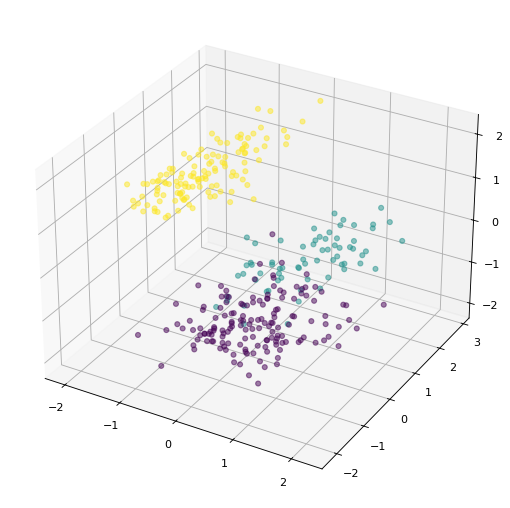

In [67]:
fig = scatter3d(scaled[:, 1:4], colors)

In [22]:
preview_info.features

FeaturesDict({
    'body_mass_g': float32,
    'culmen_depth_mm': float32,
    'culmen_length_mm': float32,
    'flipper_length_mm': float32,
    'island': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'sex': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})

### Try Dimension Reduction

In [45]:
colors = preview_df.dropna()["species"]

#### Clean Data

In [28]:
numeric_attributes = ["body_mass_g", "culmen_depth_mm", "culmen_length_mm", "flipper_length_mm"]
preview_numeric_df = preview_df[numeric_attributes].dropna()

In [30]:
preview_numeric_df.info() # NOTE: equal number of non-null rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   body_mass_g        342 non-null    float32
 1   culmen_depth_mm    342 non-null    float32
 2   culmen_length_mm   342 non-null    float32
 3   flipper_length_mm  342 non-null    float32
dtypes: float32(4)
memory usage: 8.0 KB


#### Scale Data

In [36]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(preview_numeric_df)
pd.DataFrame(scaled).describe()

,0,1,2,3
count,3.420000e+02,3.420000e+02,3.420000e+02,3.420000e+02
mean,2.788521e-09,2.230817e-08,-2.788521e-09,-1.394261e-08
std,1.001465e+00,1.001465e+00,1.001465e+00,1.001465e+00
min,-1.875362e+00,-2.054446e+00,-2.168527e+00,-2.059320e+00
25%,-8.138982e-01,-7.866353e-01,-8.615696e-01,-7.773731e-01
50%,-1.895079e-01,7.547510e-02,9.686540e-02,-2.788381e-01
75%,6.846384e-01,7.854496e-01,8.397669e-01,8.606704e-01
max,2.620248e+00,2.205397e+00,2.875868e+00,2.142618e+00


**NOTE**: Now all the data has $mean \approx 0$ and $std \approx 1.0$

#### UMAP

In [46]:
import umap

reducer = umap.UMAP(n_components=2)
embeddings_umap = reducer.fit_transform(scaled)

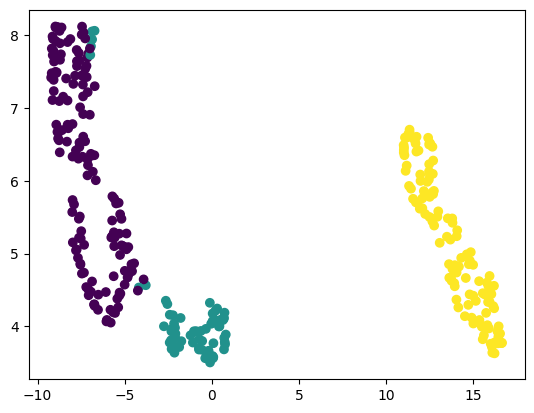

In [48]:
plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=colors)

#### PaCMAP

In [44]:
import pacmap

reducer = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
embeddings_pacmap = reducer.fit_transform(scaled)

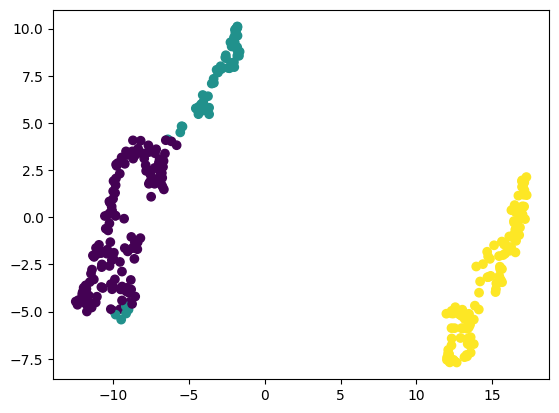

In [49]:
plt.scatter(embeddings_pacmap[:, 0], embeddings_pacmap[:, 1], c=colors)

#### TriMAP

In [50]:
import trimap

reducer = trimap.TRIMAP()
embeddings_trimap = reducer.fit_transform(scaled)

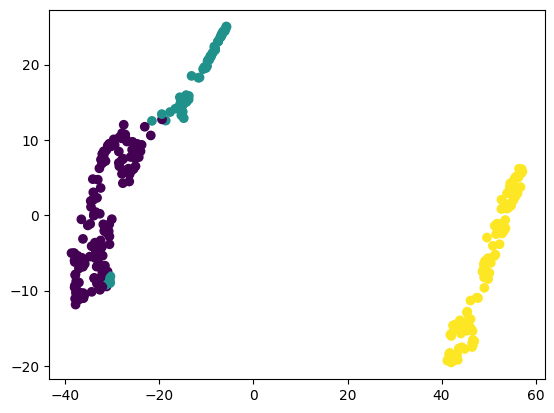

In [51]:
plt.scatter(embeddings_trimap[:, 0], embeddings_trimap[:, 1], c=colors)

#### t-SNE

In [54]:
from sklearn.manifold import TSNE

reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
embeddings_tsne = reducer.fit_transform(scaled)

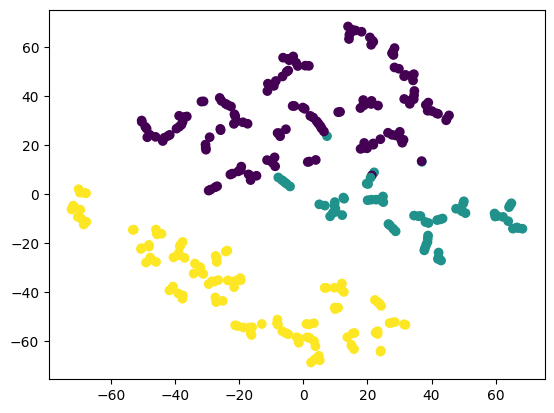

In [55]:
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=colors)

## Get Preprocessed Data

The default [penguins/processed](https://www.tensorflow.org/datasets/catalog/penguins) dataset is already cleand, normalized and  ready for building a model. 

In [68]:
(test_dataset, train_dataset), info = tfds.load('penguins/processed', split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)

In [72]:
len(test_dataset), len(train_dataset)

(67, 267)

In [73]:
info.features

FeaturesDict({
    'features': Tensor(shape=(4,), dtype=float32),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})

In [75]:
test_df = tfds.as_dataframe(test_dataset, info)
train_df = tfds.as_dataframe(train_dataset, info)

In [76]:
train_df.info()

<class 'tensorflow_datasets.core.as_dataframe.as_dataframe.<locals>.StyledDataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   features  267 non-null    object
 1   species   267 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.3+ KB


In [78]:
train_df.head()

,features,species
0,"[0.49818182, 0.6904762, 0.42372882, 0.4027778]",0
1,"[0.48, 0.071428575, 0.6440678, 0.44444445]",2
2,"[0.7236364, 0.9047619, 0.6440678, 0.5833333]",1
3,"[0.34545454, 0.5833333, 0.33898306, 0.3472222]",0
4,"[0.10909091, 0.75, 0.3559322, 0.41666666]",0


## Build a Simple Linear Model

We will use [Keras](https://keras.io/) API to build a model as a [sequence](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) of [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers.

In [116]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=10, activation=tf.nn.relu, input_shape=(4,)),
    tf.keras.layers.Dense(units=10, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=3), # Default is "linear" activation
])

**NOTE**: we only provide `input_shape` to the first layer. This is because Keras creates layer 
state lazily, upon the first call, inside the `build(input_shape)` method. See [tf.keras.Layer](https://www.tensorflow.org/api_docs/python/tf/keras/Layer) docs for more details. 

In [83]:
model(tf.constant([[1, 1, 2, 2]]))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.6170919 ,  0.24170363, -0.10348973]], dtype=float32)>

## Train the Model

### Define Loss

In [84]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [85]:
def calculate_loss(model, x, y, training:bool, loss_function):
    y_predicted = model(x, training=training)
    return loss_function(y_true=y, y_pred=y_predicted)

In [86]:
features, labels = next(iter(train_dataset.batch(32)))

In [89]:
features

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[0.49818182, 0.6904762 , 0.42372882, 0.4027778 ],
       [0.48      , 0.07142857, 0.6440678 , 0.44444445],
       [0.7236364 , 0.9047619 , 0.6440678 , 0.5833333 ],
       [0.34545454, 0.5833333 , 0.33898306, 0.3472222 ],
       [0.10909091, 0.75      , 0.3559322 , 0.41666666],
       [0.6690909 , 0.63095236, 0.47457626, 0.19444445],
       [0.8036364 , 0.9166667 , 0.4915254 , 0.44444445],
       [0.4909091 , 0.75      , 0.37288135, 0.22916667],
       [0.33454546, 0.85714287, 0.37288135, 0.2361111 ],
       [0.32      , 0.41666666, 0.2542373 , 0.1388889 ],
       [0.41454545, 0.5952381 , 0.5084746 , 0.19444445],
       [0.14909092, 0.48809522, 0.2542373 , 0.125     ],
       [0.23636363, 0.4642857 , 0.27118644, 0.05555556],
       [0.22181818, 0.5952381 , 0.22033899, 0.3472222 ],
       [0.24727273, 0.5595238 , 0.15254237, 0.25694445],
       [0.63272727, 0.35714287, 0.88135594, 0.8194444 ],
       [0.47272727, 0.15476191, 0.64406

In [90]:
labels

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0,
       2, 2, 1, 2, 0, 2, 2, 2, 2, 0])>

In [91]:
calculate_loss(model, features, labels, training=True, loss_function=loss_function)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0481805>

### Calculate Gradient

In [92]:
def grad(model, inputs, targets, loss_function):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, inputs, targets, training=True, loss_function=loss_function)
    return loss, tape.gradient(loss, model.trainable_variables)

### Create Optimizer

In [117]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

#### Example

In [94]:
loss, grads = grad(model, features, labels, loss_function)

In [95]:
optimizer.apply_gradients(zip(grads, model.trainable_variables))

<KerasVariable shape=(), dtype=int64, path=SGD/iteration>

### Training Loop

In [118]:
from typing import List
from dataclasses import dataclass, field


@dataclass
class TrainingHistory:
    """Training history report."""
    loss: List[float] = field(default_factory=list)
    accuracy: List[float] = field(default_factory=list)

    def update_state(self, loss, accuracy):
        self.loss.append(loss)
        self.accuracy.append(accuracy)


    def plot(self, fig=None):
        fig = fig or plt.figure(figsize=(10,10))
        accuracy = fig.add_subplot(1, 2, 1)
        accuracy.plot(range(len(self.accuracy)), self.accuracy, label="Accuracy")
        accuracy.grid()
        accuracy.legend()

        loss = fig.add_subplot(1, 2, 2)
        loss.plot(range(len(self.loss)), self. loss, label="Loss")
        loss.grid()
        loss.legend()


def train_step(model, batches, optimizer, loss_function):
    loss_avg = tf.keras.metrics.Mean()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    for inputs, targets in batches:
        loss, grads = grad(model, inputs, targets, loss_function)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        loss_avg.update_state(loss)
        accuracy.update_state(targets, model(inputs, training=True))

    return loss_avg.result(), accuracy.result()


def train_loop(model, dataset, epochs, optimizer, loss_function):
    history = TrainingHistory()
    for epoch in range(epochs):
        loss, accuracy = train_step(model, dataset.batch(32), optimizer, loss_function)

        print(f"Epoch {epoch}: Loss: {loss:.3f}, Accuracy: {accuracy:.3%}")
        history.update_state(loss, accuracy)
    return history

In [119]:
num_epochs = 400
history = train_loop(model, train_dataset, num_epochs, optimizer, loss_function) 

Epoch 0: Loss: 1.059, Accuracy: 25.468%
Epoch 1: Loss: 1.050, Accuracy: 35.955%
Epoch 2: Loss: 1.043, Accuracy: 50.187%
Epoch 3: Loss: 1.037, Accuracy: 64.419%
Epoch 4: Loss: 1.031, Accuracy: 68.539%
Epoch 5: Loss: 1.025, Accuracy: 68.539%
Epoch 6: Loss: 1.020, Accuracy: 69.663%
Epoch 7: Loss: 1.014, Accuracy: 70.037%
Epoch 8: Loss: 1.009, Accuracy: 71.161%
Epoch 9: Loss: 1.004, Accuracy: 73.034%
Epoch 10: Loss: 0.999, Accuracy: 74.157%
Epoch 11: Loss: 0.994, Accuracy: 74.157%
Epoch 12: Loss: 0.988, Accuracy: 74.532%
Epoch 13: Loss: 0.983, Accuracy: 74.532%
Epoch 14: Loss: 0.977, Accuracy: 75.281%
Epoch 15: Loss: 0.972, Accuracy: 75.281%
Epoch 16: Loss: 0.966, Accuracy: 75.281%
Epoch 17: Loss: 0.960, Accuracy: 76.030%
Epoch 18: Loss: 0.954, Accuracy: 76.404%
Epoch 19: Loss: 0.948, Accuracy: 76.404%
Epoch 20: Loss: 0.942, Accuracy: 76.779%
Epoch 21: Loss: 0.936, Accuracy: 76.779%
Epoch 22: Loss: 0.929, Accuracy: 76.779%
Epoch 23: Loss: 0.923, Accuracy: 76.779%
Epoch 24: Loss: 0.917, Acc

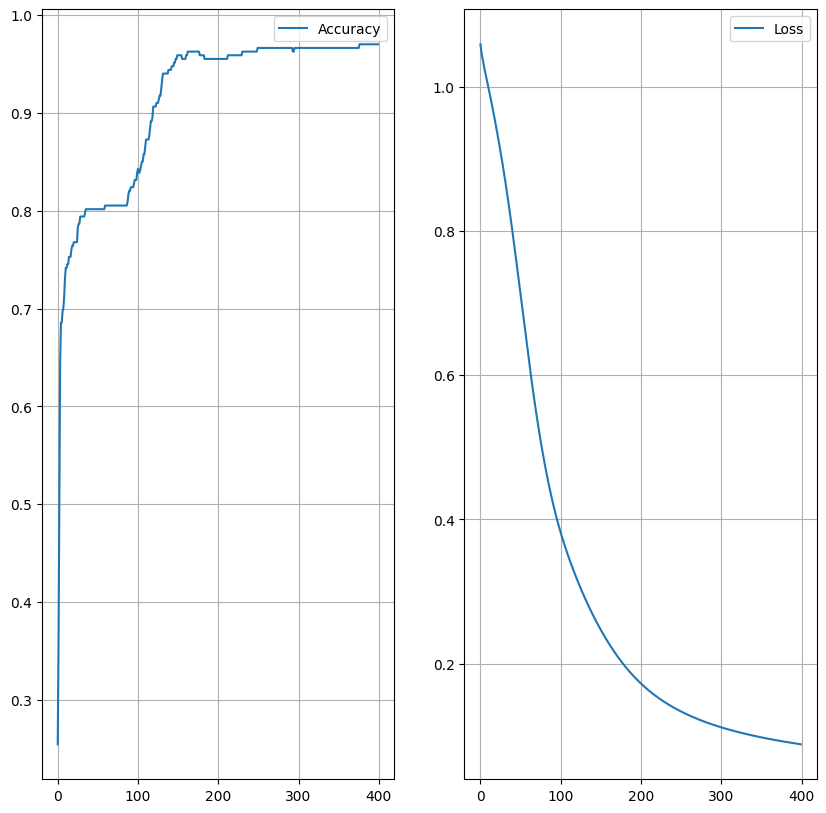

In [120]:
history.plot()

## Evaluate Model Effectiveness

In [123]:
def evaluate(model, test_dataset):
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    for inputs, targets in test_dataset.batch(32):
        logits = model(inputs, training=False)
        accuracy.update_state(targets, logits)
        
    return accuracy.result().numpy()

In [124]:
accuracy = evaluate(model, test_dataset)
print(f"Test set accuracy: {accuracy:.3%}")

Test set accuracy: 97.015%
